In [39]:
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
load_dotenv()
import warnings
warnings.filterwarnings('ignore')
import mplfinance as mpf

api_key = os.getenv("BINANCE_API_KEY")
api_secret = os.getenv("BINANCE_API_SECRET")
client = Client(api_key=api_key, api_secret=api_secret)

In [40]:
symbol = 'ENAUSDT'
interval = '15m'

In [41]:
def get_ohlc_hourly():
    try:
        interval = '1h'
        end_time = datetime.now() - timedelta(days=2)
        start_time = end_time - timedelta(days=12)

        print(end_time.strftime("%Y-%m-%d %H:%M")) # 현재 시간

        start_timestamp = int(start_time.timestamp() * 1000)
        end_timestamp = int(end_time.timestamp() * 1000)

        klines = client.get_historical_klines(symbol, interval, start_timestamp, end_timestamp)

        ohlc_hour = []
        for kline in klines:
            timestamp = datetime.fromtimestamp(kline[0] / 1000).strftime('%Y-%m-%d %H:%M:%S')
            open_price = float(kline[1])
            high_price = float(kline[2])
            low_price = float(kline[3])
            close_price = float(kline[4])
            volume = float(kline[5])
            ohlc_hour.append([timestamp, open_price, high_price, low_price, close_price, volume])

        ohlc_hour = pd.DataFrame(ohlc_hour, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

        ohlc_hour['Timestamp'] = pd.to_datetime(ohlc_hour['Timestamp'])

        return ohlc_hour
    
    except Exception as e:
        print("get_ohlc_hour() Exception:", e)

In [42]:
def get_ohlc_30_min():
    try:
        end_time = datetime.now()
        start_time = end_time - timedelta(days=2)

        start_timestamp = int(start_time.timestamp() * 1000)
        end_timestamp = int(end_time.timestamp() * 1000)

        klines = client.get_historical_klines(symbol, interval, start_timestamp, end_timestamp)

        ohlc_30_min = []
        for kline in klines:
            timestamp = datetime.fromtimestamp(kline[0] / 1000).strftime('%Y-%m-%d %H:%M:%S')
            open_price = float(kline[1])
            high_price = float(kline[2])
            low_price = float(kline[3])
            close_price = float(kline[4])
            volume = float(kline[5])
            ohlc_30_min.append([timestamp, open_price, high_price, low_price, close_price, volume])

        ohlc_30_min = pd.DataFrame(ohlc_30_min, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

        ohlc_30_min['Timestamp'] = pd.to_datetime(ohlc_30_min['Timestamp'])

        print(end_time.strftime("%Y-%m-%d %H:%M"))

        return ohlc_30_min
    
    except Exception as e:
        print("get_ohlc_30_min() Exception:", e)

In [43]:
def get_ohlc():
    ohlc_hour = get_ohlc_hourly()
    ohlc_30_min = get_ohlc_30_min()
    ohlc_df = pd.concat([ohlc_hour, ohlc_30_min])
    return ohlc_df

In [45]:
def calculate_atr(df):
    try :
        df['High-Low'] = df['High'] - df['Low']
        df['High-PreviousClose'] = abs(df['High'] - df['Close'].shift(1))
        df['Low-PreviousClose'] = abs(df['Low'] - df['Close'].shift(1))
        df['TrueRange'] = df[['High-Low', 'High-PreviousClose', 'Low-PreviousClose']].max(axis=1)

        period = 14
        df['ATR'] = df['TrueRange'].rolling(period).mean()

        df.drop(['High-Low', 'High-PreviousClose', 'Low-PreviousClose', 'TrueRange'], axis=1, inplace=True)
        
        df = df.tail(96)
        return df
    
    except Exception as e:
        print("calculage_atr() Exception", e)

In [46]:
def calculate_atr_trailing_stop(df):
    try:
        df['ATR_Trailing_Stop'] = df['Close']
        df = df.reset_index()

        for i in range(1, len(df)):
            n_loss = 2 * df.iloc[i]['ATR']
            close = df.iloc[i]['Close']
            prev_close = df.iloc[i - 1]['Close']
            prev_atr_trailing_stop = df.iloc[i - 1]['ATR_Trailing_Stop']

            if close > prev_atr_trailing_stop and prev_close > prev_atr_trailing_stop:
                df.at[i, 'ATR_Trailing_Stop'] = max(prev_atr_trailing_stop, close - n_loss)
            elif close < prev_atr_trailing_stop and prev_close < prev_atr_trailing_stop:
                df.at[i, 'ATR_Trailing_Stop'] = min(prev_atr_trailing_stop, close + n_loss)
            elif close > prev_atr_trailing_stop:
                df.at[i, 'ATR_Trailing_Stop'] = close - n_loss
            elif close <= prev_atr_trailing_stop:
                df.at[i, 'ATR_Trailing_Stop'] = close + n_loss

        df.drop(['ATR'], axis=1, inplace=True)
        
        return df
    
    except Exception as e:
        print("calculate_atr_trailing_stop() Exception", e)

In [47]:
def if_crossover(df):
    try :
        #  crossover
        #  0 : Initial value, No Crossover 

        #  1 : Upward Crossover
        # prev_close <= prev_atr_trailing_stop and open >= atr_trailing_stop
        # prev_open <= prev_atr_trailing_stop and open >= atr_trailing_stop

        # -1 : Downward Crossover | 
        # prev_close >= prev_atr_trailing_stop and open <= atr_trailing_stop
        # prev_open >= prev_atr_trailing_stop and open <= atr_trailing_stop

        df['Crossover'] = 0

        for i in range(1, len(df)):
            prev_close = df.iloc[i-1]['Close']
            prev_open = df.iloc[i-1]['Open']
            prev_atr_trailing_stop = df.iloc[i-1]['ATR_Trailing_Stop']
            open = df.iloc[i]['Open']
            atr_trailing_stop = df.iloc[i]['ATR_Trailing_Stop']

            if prev_close <= prev_atr_trailing_stop and open >= atr_trailing_stop :
                df.at[i, 'Crossover'] = 1
            elif prev_open <= prev_atr_trailing_stop and open >= atr_trailing_stop :
                df.at[i, 'Crossover'] = 1
            elif prev_close >= prev_atr_trailing_stop and open <= atr_trailing_stop :
                df.at[i, 'Crossover'] = -1
            elif prev_open >= prev_atr_trailing_stop and open <= atr_trailing_stop :
                df.at[i, 'Crossover'] = -1
        
        return df
    except Exception as e:
        print("if_crossover() Exception", e)

In [48]:
def make_plot(ohlc_df):
    ohlc_df.set_index('Timestamp', inplace=True)

    
    ap = mpf.make_addplot(ohlc_df['ATR_Trailing_Stop'], color='blue')
    
    mpf.plot(ohlc_df, type='candle', style='charles', title='Candlestick Chart with ATR Trailing Stop',
             ylabel='Price', volume=False, addplot=[ap],
             figratio=(16, 9), figsize=(14, 7), xrotation=15)

In [49]:
ohlc_df = get_ohlc()
ohlc_df  = calculate_atr(ohlc_df)
ohlc_df = calculate_atr_trailing_stop(ohlc_df)
ohlc_df = if_crossover(ohlc_df)
crossover_df =  ohlc_df[ohlc_df['Crossover'] != 0]
print(crossover_df)

2024-04-10 17:53
2024-04-12 17:53
    index           Timestamp   Open   High    Low  Close      Volume  \
1      97 2024-04-11 18:15:00  1.408  1.442  1.405  1.436  3764756.64   
22    118 2024-04-11 23:30:00  1.481  1.489  1.443  1.445  6285978.80   
61    157 2024-04-12 09:15:00  1.408  1.430  1.396  1.414  5002819.55   
92    188 2024-04-12 17:00:00  1.459  1.470  1.440  1.441  3322249.02   

    ATR_Trailing_Stop  Crossover  
1            1.387429          1  
22           1.496571         -1  
61           1.374143          1  
92           1.474143         -1  


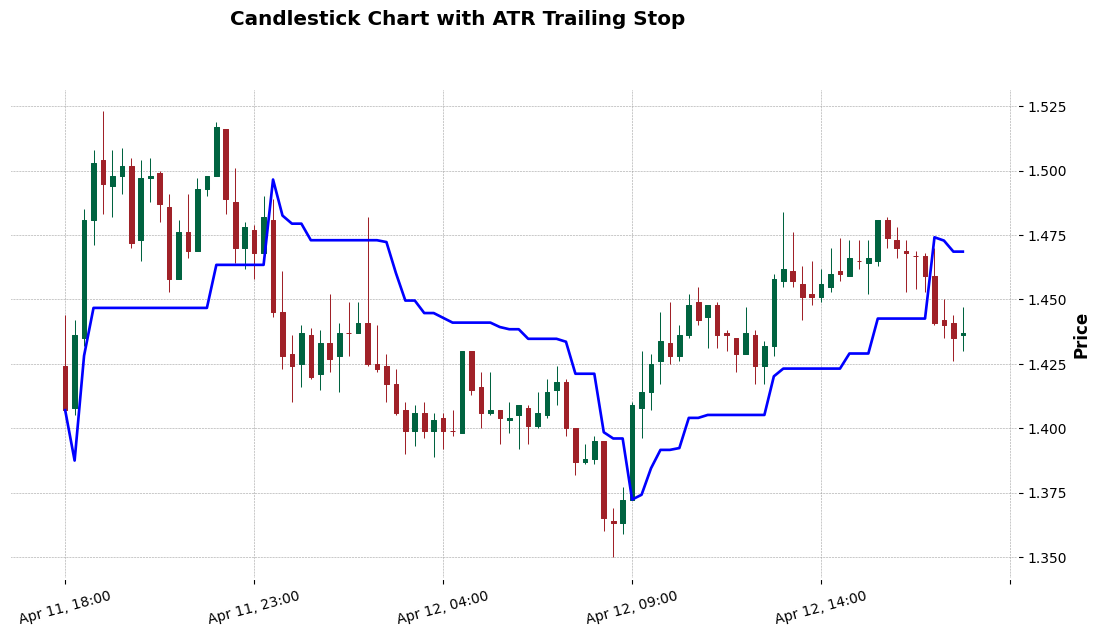

In [50]:
make_plot(ohlc_df)